# Deep Crossentropy method

In this section we'll extend your CEM implementation with neural networks! You will train a multi-layer neural network to solve simple continuous state space games. __Please make sure you're done with tabular crossentropy method from the previous notebook.__

![img](https://watanimg.elwatannews.com/old_news_images/large/249765_Large_20140709045740_11.jpg)



In [27]:
import sys, os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

c:\Users\dimaf\miniconda3\envs\rl\Lib\site-packages\gymnasium\envs\registration.py:523: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


state vector dim = 4
n_actions = 2


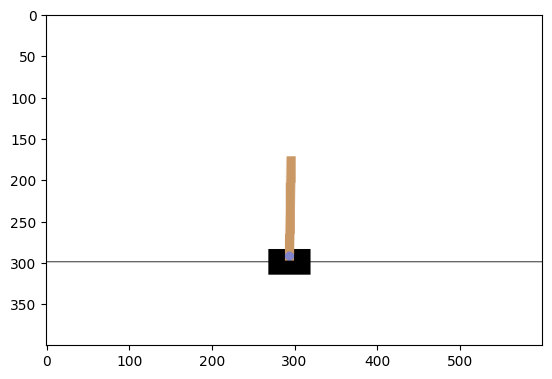

In [28]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("CartPole-v0", render_mode="rgb_array").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render())
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

env.close()

# Neural Network Policy

For this assignment we'll utilize the simplified neural network implementation from __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Here's what you'll need:

* `agent.partial_fit(states, actions)` - make a single training pass over the data. Maximize the probability of :actions: from :states:
* `agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape __[len(states), n_actions]__


In [3]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation="tanh",
)


# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))


MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [4]:
def generate_session(env, agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s, _ = env.reset()

    for t in range(t_max):

        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba(s[None,:]).reshape(-1)
        # probs = agent.predict_proba(s[None, :]).reshape(-1)
        # print(probs)

        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"

        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(np.arange(n_actions), p = probs)
        # ^-- hint: try np.random.choice

        new_s, r, terminated, truncated, _ = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if terminated or truncated:
            break
    return np.array(states), np.array(actions), np.array(total_reward)


In [5]:
dummy_states, dummy_actions, dummy_reward = generate_session(env, agent, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)

states: [[-0.01228261 -0.03906056  0.00280724  0.00656324]
 [-0.01306382 -0.23422267  0.00293851  0.30013058]
 [-0.01774828 -0.03914272  0.00894112  0.00837583]
 [-0.01853113 -0.23439175  0.00910863  0.30386633]
 [-0.02321897 -0.42964232  0.01518596  0.5994079 ]]
actions: [0 1 0 0 0]
reward: 5.0


### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

The only difference is that now each observation is not a number but a `float32` vector.

In [6]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)
    elite_states = []
    elite_actions = []
    for i, r in enumerate(rewards_batch):
        if r >= reward_threshold:
            elite_states.extend(states_batch[i])
            elite_actions.extend(actions_batch[i])
    return elite_states, elite_actions


# Training loop
Generate sessions, select N best and fit to those.

In [7]:
from IPython.display import clear_output


def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label="Mean rewards")
    plt.plot(list(zip(*log))[1], label="Reward thresholds")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines(
        [np.percentile(rewards_batch, percentile)],
        [0],
        [100],
        label="percentile",
        color="red",
    )
    plt.legend()
    plt.grid()

    plt.show()


mean reward = 37.580, threshold=43.000


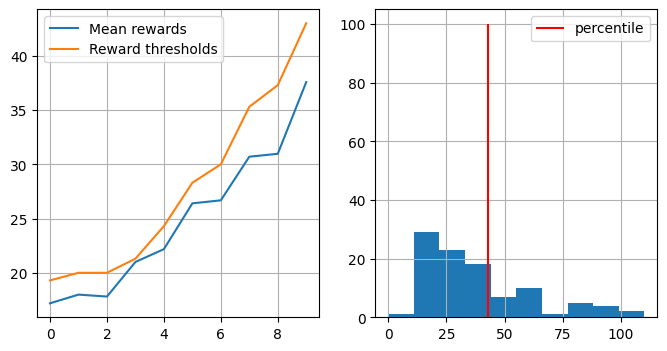

In [8]:
n_sessions = 100
percentile = 70
log = []

for i in range(10):
    # generate new sessions
    sessions = [generate_session(env, agent) for i in range(n_sessions)]

    
    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    agent.partial_fit(elite_states, elite_actions)

    show_progress(
        rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)]
    )

    if np.mean(rewards_batch) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")


In [11]:
env = gym.make("MountainCar-v0").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

Create an agent

In [12]:
agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation="tanh",
)

In [13]:
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

mean reward = -142.980, threshold=-142.000


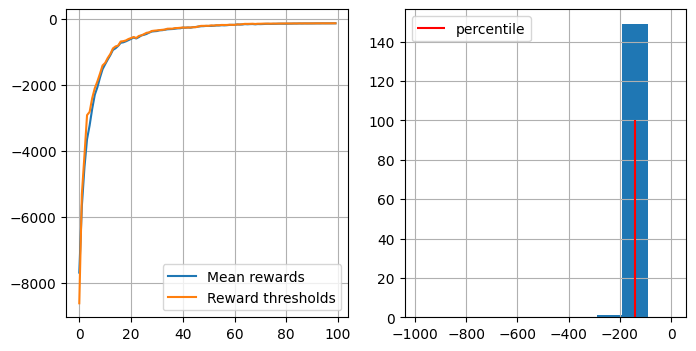

In [14]:
from joblib import Parallel, delayed

def train_agent(env, agent, n_sessions, percentile, t_max=10**4):
    log = []

    for i in range(100):
        # Generate new sessions in parallel
        sessions = Parallel(n_jobs=-1)(delayed(generate_session)(env, agent, t_max) for _ in range(n_sessions))

        states_batch, actions_batch, rewards_batch = zip(*sessions)

        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

        agent.partial_fit(elite_states, elite_actions)

        show_progress(rewards_batch, log, percentile)

# Usage
train_agent(env, agent, n_sessions=150, percentile=50)

c:\Users\dimaf\miniconda3\envs\rl\Lib\site-packages\gymnasium\envs\registration.py:787: UserWarning: WARN: The environment is being initialised with render_mode='rgb_arrary' that is not in the possible render_modes (['human', 'rgb_array']).
  logger.warn(


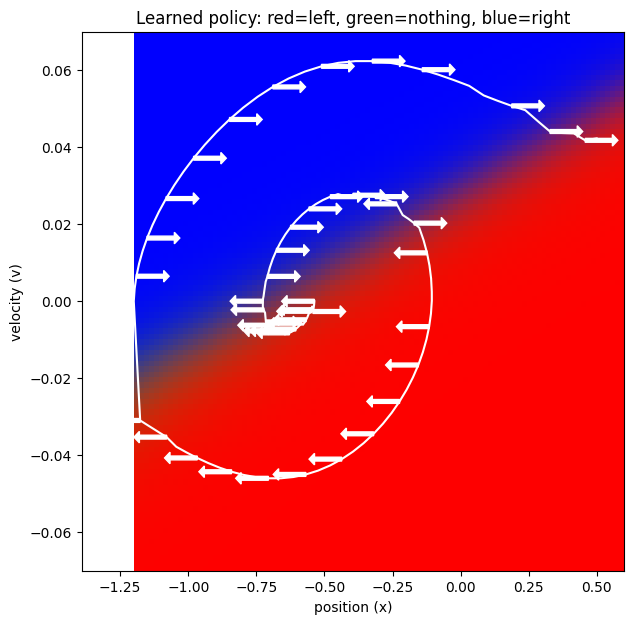

In [16]:
def visualize_mountain_car(env, agent):
    # Compute policy for all possible x and v (with discretization)
    xs = np.linspace(env.min_position, env.max_position, 100)
    vs = np.linspace(-env.max_speed, env.max_speed, 100)

    grid = np.dstack(np.meshgrid(xs, vs[::-1])).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = (
        agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3).transpose(1, 0, 2)
    )

    # # The above code is equivalent to the following:
    # probs = np.empty((len(vs), len(xs), 3))
    # for i, v in enumerate(vs[::-1]):
    #     for j, x in enumerate(xs):
    #         probs[i, j, :] = agent.predict_proba([[x, v]])[0]

    # Draw policy
    f, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(
        probs,
        extent=(env.min_position, env.max_position, -env.max_speed, env.max_speed),
        aspect="auto",
    )
    ax.set_title("Learned policy: red=left, green=nothing, blue=right")
    ax.set_xlabel("position (x)")
    ax.set_ylabel("velocity (v)")

    # Sample a trajectory and draw it
    states, actions, _ = generate_session(env, agent)
    states = np.array(states)
    ax.plot(states[:, 0], states[:, 1], color="white")

    # Draw every 3rd action from the trajectory
    for (x, v), a in zip(states[::3], actions[::3]):
        if a == 0:
            plt.arrow(x, v, -0.1, 0, color="white", head_length=0.02)
        elif a == 2:
            plt.arrow(x, v, 0.1, 0, color="white", head_length=0.02)


with gym.make("MountainCar-v0", render_mode="rgb_arrary").env as env:
    visualize_mountain_car(env, agent)
